In [ ]:
#You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import csv
#import emoji
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from collections import Counter
from gensim.models import Word2Vec
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import classification_report, confusion_matrix
import random
seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
import time
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-3-cfed0ab01b88>:43: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [ ]:
df=pd.read_csv('cyberbullying_tweets.csv')

In [ ]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
df.shape

(28848, 2)

In [ ]:
df.info()
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28848 entries, 0 to 28847
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          28848 non-null  object
 1   cyberbullying_type  28847 non-null  object
dtypes: object(2)
memory usage: 450.9+ KB


34

In [ ]:
df = df[~df.duplicated()]
df.info()
df.sentiment.value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 28814 entries, 0 to 28847
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       28814 non-null  object
 1   sentiment  28813 non-null  object
dtypes: object(2)
memory usage: 675.3+ KB


sentiment
religion               7997
gender                 7948
not_cyberbullying      7937
other_cyberbullying    4931
Name: count, dtype: int64

In [ ]:
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14)
    return text
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])
def deep_clean(text):
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [ ]:
texts_new = []
for t in df.text:
    texts_new.append(deep_clean(t))

In [ ]:
df['text_clean'] = texts_new
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock today sunris studi...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account like islam...


In [ ]:
df["text_clean"].duplicated().sum()

1948

In [ ]:
df.drop_duplicates("text_clean", inplace=True)

In [ ]:
df.shape

(26866, 3)

In [ ]:
df.sentiment.value_counts()

sentiment
religion               7946
not_cyberbullying      7637
gender                 7607
other_cyberbullying    3676
Name: count, dtype: int64

In [ ]:
df = df[df["sentiment"]!="other_cyberbullying"]
sentiments = ["religion","age","ethnicity","gender","not bullying"]

In [ ]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [ ]:
df['text_len'] = text_len

<ipython-input-22-78b689ac0360>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='flare')


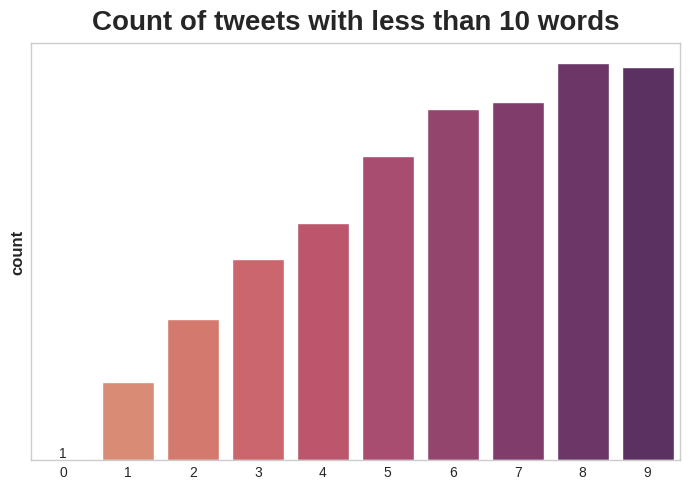

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='flare')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
df = df[df['text_len'] > 3]

In [ ]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,research push import top antibulli program us ...,137
15621,"@ufcpride40: : Terry Bean, prominent gay activ...",gender,terri bean promin gay activist major obama dem...,120
10922,don't make rape jokes!!! don't make gay jokes!...,gender,make rape joke make gay joke oh fat joke okay ...,120
14168,IT CALLS THE FUNCTION TO THE PROCESS OR IT GE…...,gender,call function process ge punk ass low self est...,116
3030,He embellished the afternoon with moustachioed...,not_cyberbullying,embellish afternoon moustachio feint amp flick...,103
...,...,...,...,...
6848,@AMohedin @halalflaws @haroonstyles @islamdefe...,not_cyberbullying,translat knew arab right,4
22439,So she is a lying Christian woman then. Do I h...,religion,lie christian woman right,4
781,@jesicadiniz kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk p...,not_cyberbullying,para vei issso bulli,4
6869,@sclancey2 -said everyone in high school,not_cyberbullying,said everyon high school,4


from matplotlib import pyplot as plt
_df_0['text_len'].plot(kind='hist', bins=20, title='text_len')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['text_len'].plot(kind='line', figsize=(8, 4), title='text_len')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='text_len', y='sentiment', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

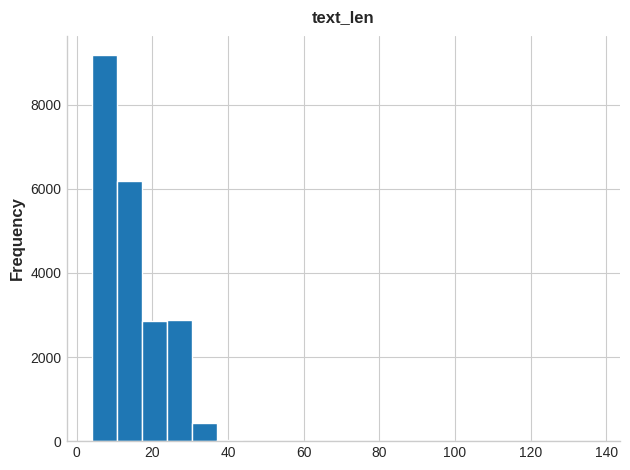

In [ ]:
from matplotlib import pyplot as plt
_df_0['text_len'].plot(kind='hist', bins=20, title='text_len')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from matplotlib import pyplot as plt
_df_2['text_len'].plot(kind='line', figsize=(8, 4), title='sentiment')
plt.gca().spines[['top', 'right']].set_visible(False)

NameError: name '_df_2' is not defined

<ipython-input-31-41d932e86474>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(_df_3, x='text_len', y='sentiment', inner='box', palette='Dark2')


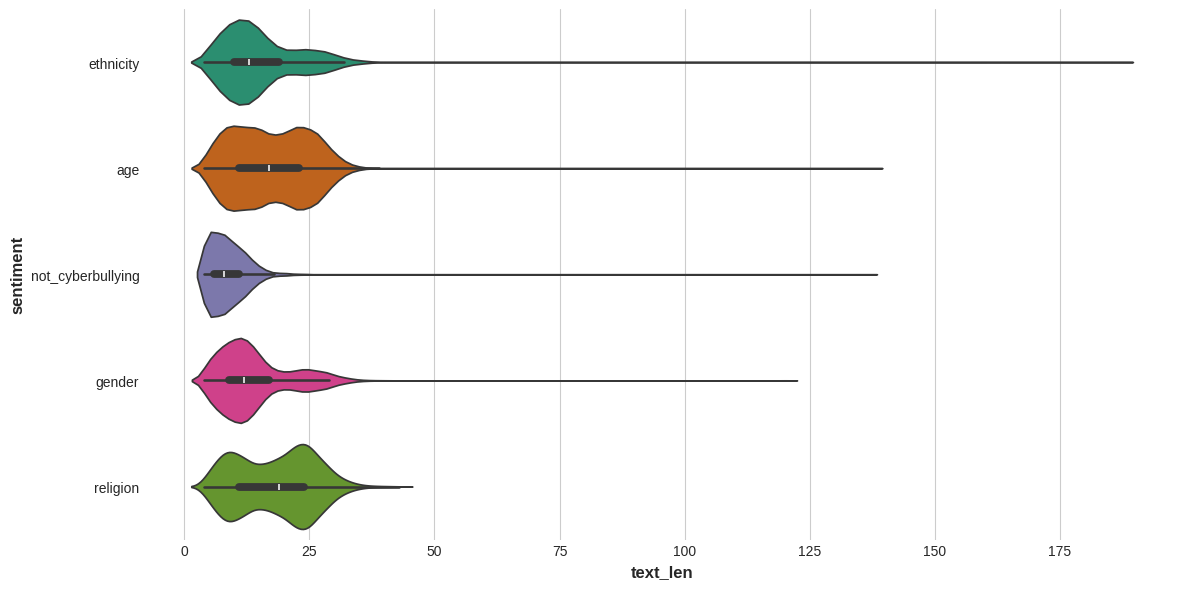

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='text_len', y='sentiment', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-36-5a7c2f4c8798>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='magma')


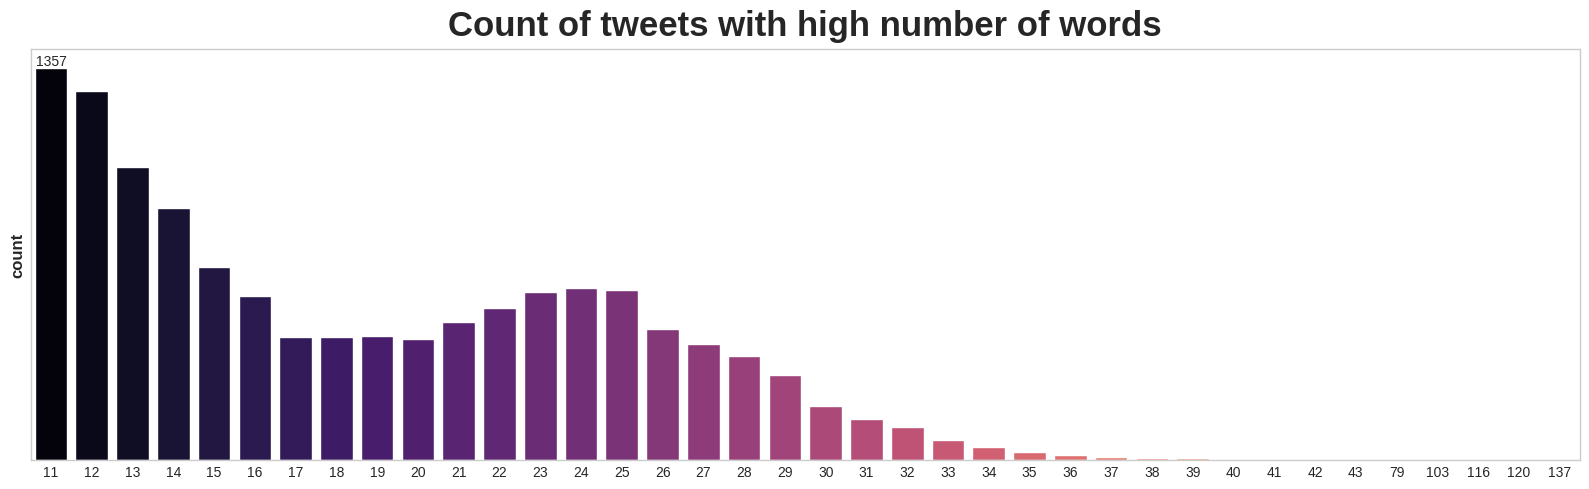

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='magma')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
df = df[df['text_len'] < 100]

In [ ]:
max_len = np.max(df['text_len'])
max_len

79

In [ ]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
4846,@andrea_gcav: @viviaanajim recuerdas como noso...,not_cyberbullying,recuerda como nosotra tambin eramo victima del...,79
44294,@JasmineLovvee If He Dont Want You Well Fuck H...,ethnicity,dont want well fuck aint worth tear never swea...,73
45930,"Get off ur ego trip, take off ur rose colored ...",ethnicity,get ur ego trip take ur rose color glass amp g...,45
21241,And yet God was able to meet their needs using...,religion,yet god abl meet need use radic everyday gener...,43
41749,@seijohgorl hoy mami keito AAAA okay so um ika...,ethnicity,hoy mami keito aaaa okay um ikaw talaga one fi...,43
...,...,...,...,...
44750,What the fuck you dumb nigger I hate you now,ethnicity,fuck dumb nigger hate,4
1673,@UMTony lmao! I really wanted to take it down!,not_cyberbullying,lmao realli want take,4
35335,He's a grade school bully. He's a coward!,age,grade school bulli coward,4
3920,Need to let my anger out dude.,not_cyberbullying,need let anger dude,4


In [ ]:
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

In [ ]:
X = df['text_clean']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=20)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=20)
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5638],
       [   2, 5549],
       [   3, 5264],
       [   4, 4587]])

In [ ]:
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5683],
       [   2, 5683],
       [   3, 5683],
       [   4, 5683]])

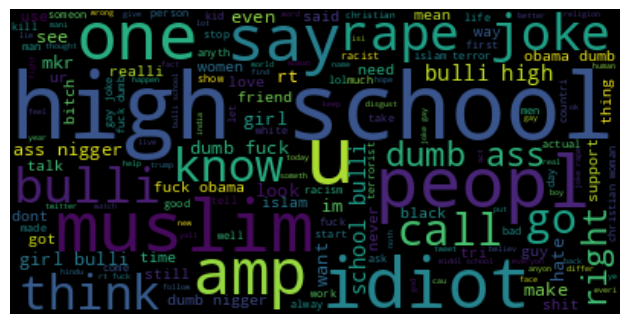

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud
consolidated = ' '.join(word for word in df['text_clean'])

wordCloud = WordCloud(width=400, height=200, random_state=20, max_font_size=119).generate(consolidated)

plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: xlabel='sentiment', ylabel='text_len'>

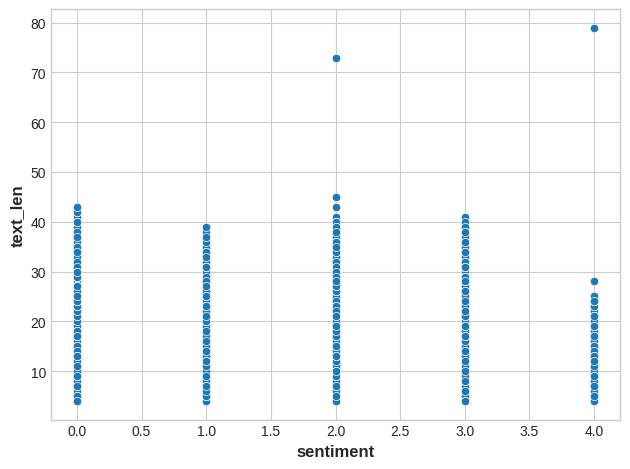

In [ ]:
# prompt: sns.scatterplot

sns.scatterplot(x = df.sentiment, y = df.text_len)
